# Assignment objective

We have data from Raleigh, NC, where we recently deployed a flyer program in order to increase public awareness of the possibility of taking a Pagaya loan. You objective is to assess the potency of the flyer program in terms of activation by analyzing production and TU data obtained from the town.


# Basic imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
import random
from scipy.sparse import csr_matrix
from IPython.display import Latex
from statsmodels.stats.multitest import multipletests

# Data preparation

## Data from TU 

To begin with, upload TUs credit information from the relevant quarter (which is 2018Q3). This data is available in our `s3` path under the name `tu_gen_data2018Q3.parquet`. To get to our `s3` path import `DATA_FILES_PATH` from `pagayapro.paths.data_paths`

In [2]:
from pagayapro.paths.data_paths import DATA_FILES_PATH

read the parquet file from `s3`. Only read the columns ["sequence_num", "credit_score", "listing_term", "int_rate", "loan_amnt", "monthly_pmt", "original_state"]

In [3]:
tu_data= pd.read_parquet(
    os.path.join(DATA_FILES_PATH,"tu_gen_data_2018Q3.parquet"),
                columns = ["sequence_num", "credit_score", 
                           "listing_term", "int_rate" ,
                           "loan_amnt", "monthly_pmt", 
                           "original_state"])

Output the first 5 rows of tu_data

In [4]:
tu_data.head()

,sequence_num,credit_score,listing_term,int_rate,loan_amnt,monthly_pmt,original_state
id,,,,,,,
adf5219e4cb985352184eb7fa597737e4a9777f7354f7a8a58270da147792561,d0820401b209782dae4284b3dd96b41e08c3e8566fbb33...,814,36.0,7.86,5500.0,172.0,MI
0a0f130443af4c6597bb074942970eaddeb125d398e2cca42175c56befc8a171,2f05cd66cb998e5e55f6f296344b271b2b89b996c7c037...,800,36.0,7.91,20000.0,626.0,NM
4ba9c6a38b650ee06b8b88a48621bd363cdf611e63400c6fc4bbffbd1bf20c47,20bdbfaf0006db032d8a4176add08fd4ef45abfb17c474...,653,36.0,30.51,3674.0,157.0,SD
dae3a344292e07d4b8935a453c37aef01303f21b2f37ccbd1c4408f158533acb,53084498c6bf053a4d1cf309e1b8ec234e503bb1a3dd4e...,623,60.0,23.46,14056.0,400.0,NC
8af2ae2462d012e4d85aa687a16a4f5fb64525928235da43c795f73dc0cadd04,f750c4ecac12ae1c156998ed3dff3f46d2d19f37250074...,627,60.0,25.55,8659.0,257.0,TN


## Activation data 

Your data regarding activation arrives as forms, detailing the loan amount, interest rate offered to the client and whether he or she accepted the offer. These are available on the assignment's `s3` path, which you can import from `pagayapro.path.data_paths` under the name `ASSIGNMENT1_DATA`, in the subdirectory `offers`. 

In [5]:
from pagayapro.paths.data_paths import ASSIGNMENT1_DATA
import glob

Read all files in the subdirectory `offers` of `ASSIGNMENT1_DATA` whose name contains the substring `raleigh`.

In [6]:
raleigh_forms= (
    glob.glob(
        os.path.join(ASSIGNMENT1_DATA,"offers/*raleigh*")
    )
)

how many forms are there?


In [7]:
len(raleigh_forms)

769

Read all the form files and create a table which contains only the last offer given to each borrower. Call this dataframe `raleigh_df`.

In [8]:
#TODO - Check if id is the only measure for duplicate offer 
df_list = []
# Read all files into dataframe list
df_list = [pd.read_csv(file_path,index_col=None,header=0) for file_path in raleigh_forms]
# Concat the data frames and sort by date
raleigh_df = pd.concat(df_list, axis=0, ignore_index=True)
raleigh_df.sort_values(by='offer_date')
print(len(raleigh_df))
raleigh_df_with_duplicates = raleigh_df.copy()
# keep the last in duplicates by id - last date an offer was given.
raleigh_df.drop_duplicates(subset='id', keep='last', inplace=True, ignore_index=False)
print(len(raleigh_df))
raleigh_df.reset_index()
raleigh_df.head()

13362
8792


,id,sequence_num,requested_amount,offered_interest_rate,offer_accepted,offer_date
0,743200d3e4cc1f6f860e121294248d611350f257a7bc83...,ec10245656d9d89186fb4e5890082eea989d5967752ce7...,3000.0,17.69,False,2018-01-01
1,e3e32f85cd78bb5002ccdc037c1818029f716e7a47911e...,3dcd131256c103fccb61c75cd79ca97fa2b5e31c4ab03e...,6899.0,12.56,False,2018-01-01
2,3a72ae7a82244f811b37c48f57469b708207004f011163...,06c005c5de6ba445d4c709b84611ac2b8542cd5d37221b...,3800.0,12.97,False,2018-01-01
3,ce770273c28ddb4f8637ae423b582f0b1617e0fe7a4880...,c49b3fce67673a9f82ed4ccaa9f75e668db48e775514fc...,13000.0,5.06,False,2018-01-01
4,7eac15c5019d5101e6434ac34202cc974b044c808958c3...,107a5b2ba3853f80df245d8644af08b74d27af77f14292...,9250.0,10.34,False,2018-01-01


How many rows are there in your table? How many distict ids?

In [9]:
raleigh_df.shape[0]

8792

In [10]:
raleigh_df.id.nunique()

8792

How can you explain the duplicate ids? Sample 5 ids with multiple lines and display them.

There are no duplicates (we got rid of them when we took "only the last offer given to each borrower")

Drop all lines in the dataframe which contain irrelevant information.

In [11]:

raleigh_df.query('offered_interest_rate > 20' ).sort_values(by="offered_interest_rate", ascending=False)





,id,sequence_num,requested_amount,offered_interest_rate,offer_accepted,offer_date
6463,89a2c6f6371a771d034a6255f209942fd3490c35ffa153...,a0a9d662d4f4c527de8ba6beee3844fcae5bd9a66d1c6f...,4000.0,39.99,False,2019-02-20
9587,b16a106eed80e19072dba0ceb9d23c8a0f642222cc8dfa...,ee446231b8201db6abc795d3aa037e8934743a37c8ec4c...,3000.0,39.81,False,2019-11-11
792,7d9216d8402d78c177ef88e81d8b2a685911b40aaf5343...,687308b3e3ccb511d34c47bdfd675dd6d332072b93ce46...,5100.0,38.32,False,2018-02-13
3667,b98dd3e134089b682f59384b6517ea0378f07fe5c16848...,0465d48e4185390ea5d167955432cc7848a2e3e0901875...,3944.0,38.14,False,2018-08-08
10834,8a7780afe69c8512b5be4319e9840a80d6d3ba31af2fbb...,b26e2b3a976556e8d9908e4ed07f1ba4a42f710feef763...,2000.0,38.08,False,2020-03-11
...,...,...,...,...,...,...
2143,d5bfdf89416f7efe41725335d55dbcc053bc1b0613d62f...,457296683933c6f0c8d6520f15387c59a414d3166431bf...,4000.0,20.01,False,2018-05-07
7046,553ec6c4547d5d5790881e6f6d539e790855671358a5ec...,8af47dc6d694608a7b4797e26789acc2000395ef0ea12c...,10000.0,20.01,False,2019-04-04
13191,fa24b59bbac798f9d0fe743a0ed6191e2cf42435700ba9...,88cb91ad96f49e523e8fb25993529fa1276503fffeedf0...,12000.0,20.01,False,2020-11-23
3434,979a61e347e6c688c55056ecdf7575e85654b265695d7b...,65a5e0cf3523290c7012d9a3f5afe94a6a59cf0ab0deca...,12000.0,20.01,False,2018-07-25


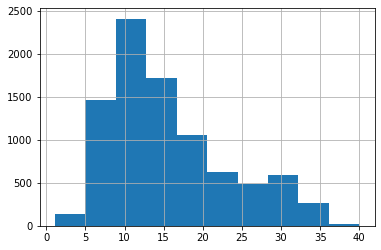

In [12]:
raleigh_df['offered_interest_rate'].hist()

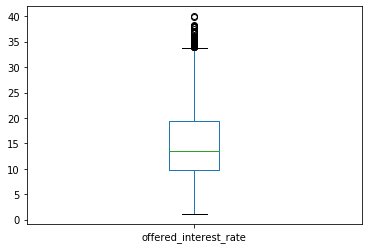

In [13]:
raleigh_df.offered_interest_rate.plot(kind='box')

we seen some extreme values in "interest rate" (40% and under 5%) we are not sure if those are outliers so we decided to keep them

What is the average interest rate offered to clients? What is the average among clients who accepted the offer?

In [14]:

print("The average interest rate offered to clients is:", raleigh_df.offered_interest_rate.mean())
print("The average interest rate offered to clients who accepted the offer is:", raleigh_df.query('offer_accepted == True').offered_interest_rate.mean())



The average interest rate offered to clients is: 15.524284576888082
The average interest rate offered to clients who accepted the offer is: 15.307480314960628


What is the percentage of activation in this dataframe?

In [15]:
raleigh_df.offer_accepted.mean()

0.08666969972702457

Enrich your dataframe with additioanl TU features by merging it with the `tu_data` df. Note that the two dataframe share the `id` and `sequence_num` features.

In [16]:
raleigh_df_merged_tu_data = pd.merge(raleigh_df,tu_data, on=['id','sequence_num'])
print(raleigh_df_merged_tu_data.shape[0])
raleigh_df_merged_tu_data.head()

8792


,id,sequence_num,requested_amount,offered_interest_rate,offer_accepted,offer_date,credit_score,listing_term,int_rate,loan_amnt,monthly_pmt,original_state
0,743200d3e4cc1f6f860e121294248d611350f257a7bc83...,ec10245656d9d89186fb4e5890082eea989d5967752ce7...,3000.0,17.69,False,2018-01-01,652,36.0,17.69,3000.0,108.0,NC
1,e3e32f85cd78bb5002ccdc037c1818029f716e7a47911e...,3dcd131256c103fccb61c75cd79ca97fa2b5e31c4ab03e...,6899.0,12.56,False,2018-01-01,735,36.0,12.56,6899.0,231.0,NC
2,3a72ae7a82244f811b37c48f57469b708207004f011163...,06c005c5de6ba445d4c709b84611ac2b8542cd5d37221b...,3800.0,12.97,False,2018-01-01,661,36.0,12.97,3800.0,128.0,NC
3,ce770273c28ddb4f8637ae423b582f0b1617e0fe7a4880...,c49b3fce67673a9f82ed4ccaa9f75e668db48e775514fc...,13000.0,5.06,False,2018-01-01,823,36.0,5.06,13000.0,390.0,NC
4,7eac15c5019d5101e6434ac34202cc974b044c808958c3...,107a5b2ba3853f80df245d8644af08b74d27af77f14292...,9250.0,10.34,False,2018-01-01,728,36.0,10.34,9250.0,300.0,NC


What is the average credit score of the clients? What is the average among clients who accepted the offer?

In [17]:
print("The average credit score of the clients is:", raleigh_df_merged_tu_data.credit_score.mean())
print("The average credit score of the clients who accepted the offer is:", raleigh_df_merged_tu_data.query('offer_accepted == True').credit_score.mean())


The average credit score of the clients is: 689.821542311192
The average credit score of the clients who accepted the offer is: 702.5446194225722


# Validations

Before we embark on a statistical test, let's do some validations to make sure that the Raleig sample is not somehow distinct from the general population. Our random sample from the general population is the TU data.

Create a histogram to describe the distribution of requested loan amounts in Raleigh and in the general population. Do the distributions look similar? (A good rule-of-thumb for the number of bins to use is the square-root of the number of unique value.)

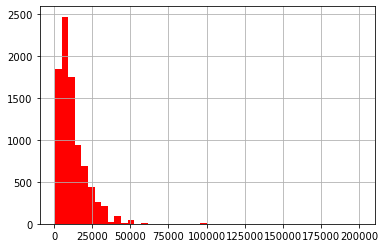

In [18]:
raleigh_df_merged_tu_data.requested_amount.hist(color ='r',bins=int(np.sqrt(raleigh_df_merged_tu_data.requested_amount.nunique())));


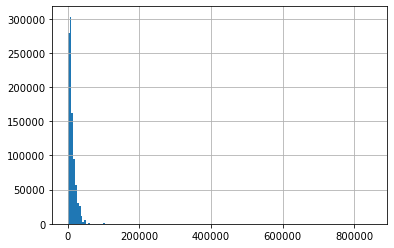

In [19]:
tu_data.loan_amnt.hist(bins=int(np.sqrt(tu_data.loan_amnt.nunique())));

Describe the loan amount distribution using `sns.distplot` in the Raleigh dataframe and in TU.

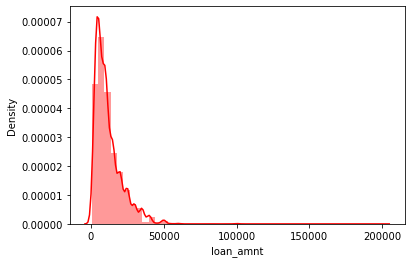

In [20]:
sns.distplot(raleigh_df_merged_tu_data.loan_amnt, color="r",bins=int(np.sqrt(raleigh_df_merged_tu_data.loan_amnt.nunique())));


In [21]:
raleigh_df_merged_tu_data.loan_amnt.describe()

count      8792.000000
mean      11752.396724
std        9534.989444
min         500.000000
25%        5000.000000
50%        9600.000000
75%       15000.000000
max      200200.000000
Name: loan_amnt, dtype: float64

Same plot without outliers:


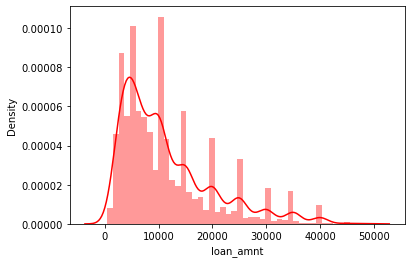

In [22]:
print("Same plot without outliers:")
sns.distplot(raleigh_df_merged_tu_data.query('loan_amnt < 50000').loan_amnt, color="r",bins=int(np.sqrt(raleigh_df_merged_tu_data.loan_amnt.nunique())));

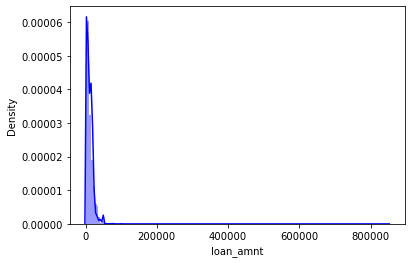

In [23]:
sns.distplot(tu_data.loan_amnt, color="b",bins=int(np.sqrt(tu_data.loan_amnt.nunique())))

In [24]:
raleigh_df_merged_tu_data.loan_amnt.describe()

count      8792.000000
mean      11752.396724
std        9534.989444
min         500.000000
25%        5000.000000
50%        9600.000000
75%       15000.000000
max      200200.000000
Name: loan_amnt, dtype: float64

Same plot without outliers:


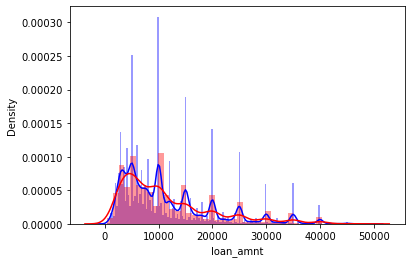

In [25]:
print("Same plot without outliers:")
sns.distplot(tu_data.query('loan_amnt <50000').loan_amnt, color="b",bins=int(np.sqrt(tu_data.loan_amnt.nunique())));
sns.distplot(raleigh_df_merged_tu_data.query('loan_amnt < 50000').loan_amnt, color="r",bins=int(np.sqrt(raleigh_df_merged_tu_data.loan_amnt.nunique())));

We also want to verify that the offered interest rate in Raleigh seem similar to those in the general population. 
Create a histogram to describe the distribution of offered interest rates in Raleigh and interest rates in the general population. Do the distributions look similar?

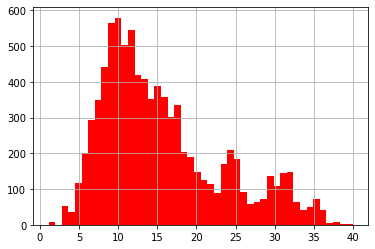

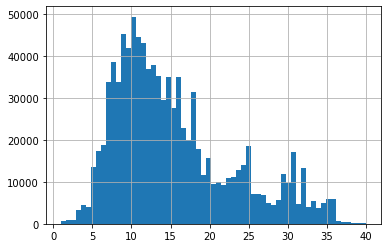

In [26]:
raleigh_df_merged_tu_data.int_rate.hist(bins=int(np.sqrt(raleigh_df_merged_tu_data.int_rate.nunique())), color="r")
plt.figure();
tu_data.int_rate.hist(bins=int(np.sqrt(tu_data.int_rate.nunique())));

Describe the interest rate distribution using `sns.distplot` in the Raleigh dataframe and in TU.

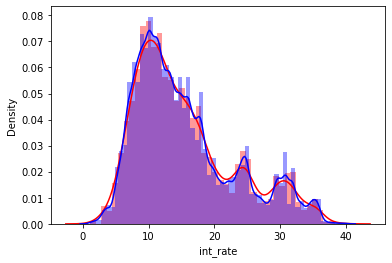

In [27]:
sns.distplot(raleigh_df_merged_tu_data.int_rate, color="r",bins=int(np.sqrt(raleigh_df_merged_tu_data.int_rate.nunique())));
sns.distplot(tu_data.int_rate, color="b",bins=int(np.sqrt(tu_data.int_rate.nunique())));

Additionally, we want to make sure the credit scores are not visibly different in Raleigh from the general population, as this might mean that the data we obtained from the town might not be representative of the general popuation.

Create a histogram to describe the distribution of credit scores in the Raleigh sample and in the general population. Do the distributions look similar? How many bins did you use?

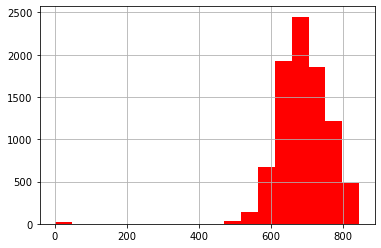

In [28]:
raleigh_df_merged_tu_data.credit_score.hist(bins=int(np.sqrt(raleigh_df_merged_tu_data.credit_score.nunique())), color="r")

Same plot as above without outliers:


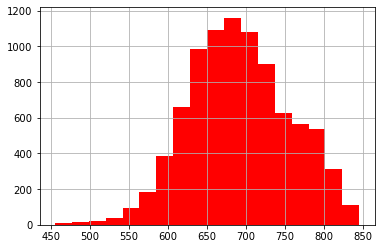

In [29]:
print("Same plot as above without outliers:")
raleigh_df_merged_tu_data.query('credit_score > 100').credit_score.hist(bins=int(np.sqrt(raleigh_df_merged_tu_data.credit_score.nunique())), color="r")

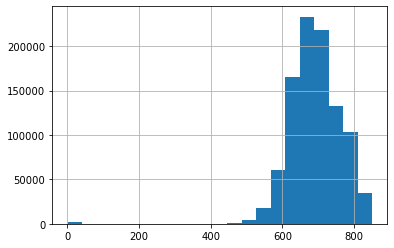

In [30]:
tu_data.credit_score.hist(bins=int(np.sqrt(tu_data.credit_score.nunique())));

Same plot as above without outliers:


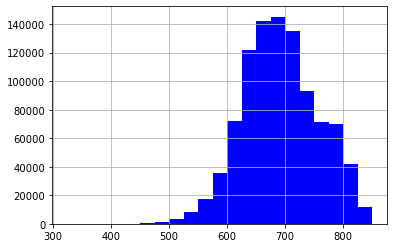

In [31]:
print("Same plot as above without outliers:")
tu_data.query('credit_score > 100').credit_score.hist(bins=int(np.sqrt(tu_data.credit_score.nunique())), color="b")

Describe the credit score distribution using `sns.distplot`  in the Raleigh dataframe and in TU.

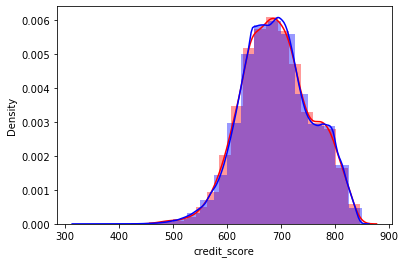

In [32]:
sns.distplot(raleigh_df_merged_tu_data.query('credit_score > 100').credit_score, color="r",bins=int(np.sqrt(raleigh_df_merged_tu_data.credit_score.nunique())));
sns.distplot(tu_data.query('credit_score > 100').credit_score, color="b",bins=int(np.sqrt(tu_data.credit_score.nunique())));

Finally, check whether the loans in both datasets have similar distributions of 4 (i.e. the amount of months the borrower takes the loan for). What values of term exist in the data?

In [33]:
raleigh_term_value_counts = raleigh_df_merged_tu_data.listing_term.value_counts()
tu_data_term_value_counts = tu_data.listing_term.value_counts()
print(raleigh_term_value_counts)
print("The ratio of people with term of 60 to the people with term 36 in raleigh is:", raleigh_term_value_counts.values.tolist()[1]/raleigh_term_value_counts.values.tolist()[0])
print(tu_data_term_value_counts)
print("The ratio of people with term of 60 to the people with term 36 in all population is:", tu_data_term_value_counts.values.tolist()[1]/tu_data_term_value_counts.values.tolist()[0])

36.0    4896
60.0    3896
Name: listing_term, dtype: int64
The ratio of people with term of 60 to the people with term 36 in raleigh is: 0.795751633986928
36.0    542102
60.0    430621
Name: listing_term, dtype: int64
The ratio of people with term of 60 to the people with term 36 in all population is: 0.7943541990252757


# CLT in action

One more thing before we start the test. Our goal is to check whether, for which we'll run some statistical test (you probably already know which) which checks if something belongs to a noraml distribution with some mean and some variance. But... is activation normally distributed in the Raliegh sample? 

The values in the columns are true false so the distribution is Bernoulli distribution

The reason why we can assume normality is because we're checking averages of samples and we're relying on the Central Limit Theorem. We won't prove the theorem, but let's test it for a bit. 

Write a function which takes a pandas series S and a natural number n and creates a series of means of samples (with replacement) of n entries from S. Decide for yourself on the length of the output series. You can also use a different data structure if you find it more suitable as the output.

In [34]:
def sample(S, n):
    length = 1000
    S = S.to_numpy()
    indices = np.random.randint(S.size, size=(length, n))
    return S[indices].mean(axis=1)

Optionally- also create a function which, given the same input as above, plots a histogram of the series of means, and also indicates the mean of this series.

In [35]:
def histogram_samples(S, n, is_alpha=1, plot=True, mean=False, color_plt = 'b'):
    samples = sample(S, n)
    bins_num = max(int(np.sqrt(np.unique(samples).size)), 10)
    plt.hist(samples, bins=bins_num, alpha=is_alpha, color=color_plt);
    if plot:
        plt.figure()
    if mean:
        return samples.mean()
        

Generate plots of the series of means of activation in Raleigh and in TU for n = 1, 2, 5, 10, 100, 1000 and 1e6, and indicate their means. Does the distribution approach a normal distribution as $n\to\infty$ in your opinion?

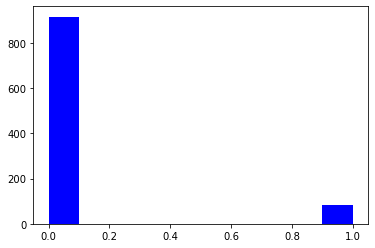

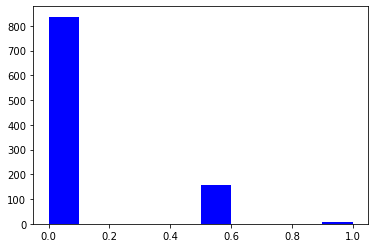

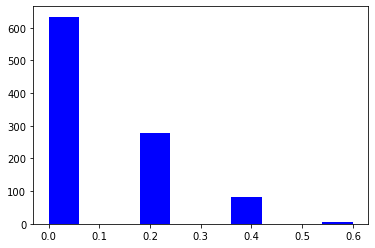

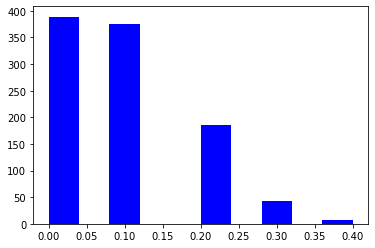

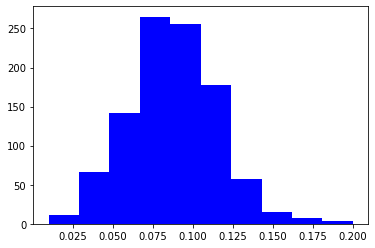

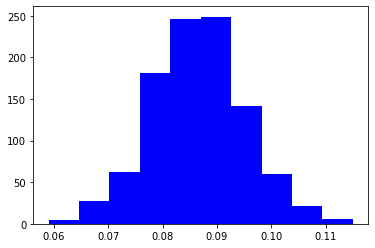

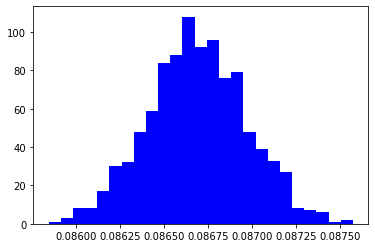

<Figure size 432x288 with 0 Axes>

In [36]:
for n in [1, 2, 5, 10, 100, 1000, 1000000]:
    histogram_samples(raleigh_df_merged_tu_data.offer_accepted, n);

Now that your fuction is ready, it's time to make it part of our infrastucture:
* Inside the `pagayapro` repo, create a branch called `feature/{your_user_name}/clt_tester/`.
* Create a file called `clt.py` inside `~/pagayapro/users/{user_name}/assignment1/` 
* Copy the two finctions you just created into the file.
* Push your file to `main`, open a PR and ask your mentor to review it. Once approved, rebase and merge.

# Statistical test 

As mentioned in the Notion doc, the activation in Raleigh before deployment was measured at 6.85%. In this section, you will run a test to check whether the activation in Raleigh is indeed different following the flyer program. 

In [37]:
from statsmodels.stats.proportion import proportions_ztest

Run a statistical test to check whether the current activation rate in Raleigh is different from 6,85%:
1. What are your hypotheses?
2. Setting your confidence level at 95%, what is the probability of an error of type I in your test? What is the probability of a type II error? What is the power of your test?
3. Is the sample mean significantly different from the past value of 6.85?
4. Interpret your results. Can you declare the program as successful in increasing activation (what is the probability of wrongfully declaring it successful)?
5. Are there any other possible explanations for the change in activation that you observed? Discuss the possible drawbacks of our current test.

Use `proportions_ztestz` from `statsmodels.stats.proportion` in order to perform the test. Are your results significant?



## Answers:

    1. H_0 - Activation rate in raleigh is 0.0685
       H_1 - Activation rate in raleigh is not 0.00685.
        
    2. $ 1- CI = \alpha => \alpha = 0.05 $
    3. We get that the mean value of raleigh_df.offer_accepted is 0.0867, which is significantly greater than 0.0685 according to the z_test.


In [38]:
from statsmodels.stats.proportion import proportions_ztest

In [39]:
mean_activation_rate_in_raleigh = raleigh_df.offer_accepted.mean()
# Try success of $H_0$
sample_success = raleigh_df.offer_accepted.sum()
sample_size = raleigh_df.offer_accepted.count()
# for $H_0$ = 0.0685
null_h = 0.0685

stat, p_value = proportions_ztest(count=sample_success, nobs=sample_size, value=null_h, alternative='two-sided')
print(stat, p_value)

6.055416376341698 1.4005491742963572e-09



Do you see any possible problems in your methodology? What other factors can explain the change in activation, if such a change exists?

Yes, it's possible that something else happened at the same time we started using fliers that can explain the increase in the activation. (a natural disaster in the arya, decline in the stock market, a factory closing etc.)

# A/b test

In order to isolate temporal and environmental effects on activation, we'll run an a/b test, comparing the activation rate in Raleigh to that of Lubbock, TX, another town in which Pagaya operates without a flyer program. 

The activation forms for Lubbock also appear in the `offers` subdirectory of the `ASSIGNMENT1_DATA` folder. Read all files from this folder whose name contains the substring 'lubbock', and create a dataframe of final offers called `lubbock_df`, drop unnecessary rows from it, and enrich it with TU features.

In [40]:
lubbock_forms= (
    glob.glob(
        os.path.join(ASSIGNMENT1_DATA,"offers/*lubbock*")
    )
)

In [41]:
#TODO - Check if id is the only measure for duplicate offer 
df_list = []
# Read all files into dataframe list
df_list = [pd.read_csv(file_path,index_col=None,header=0) for file_path in lubbock_forms]
# Concat the data frames and sort by date
lubbock_df = pd.concat(df_list, axis=0, ignore_index=True)
lubbock_df.sort_values(by='offer_date')
print(len(lubbock_df))
lubbock_df_with_duplicates = lubbock_df.copy()
# keep the last in duplicates by id - last date an offer was given.
lubbock_df.drop_duplicates(subset='id', keep='last', inplace=True, ignore_index=False)
print(len(lubbock_df))
lubbock_df.reset_index()
lubbock_df.head()

17177
11320


,id,sequence_num,requested_amount,offered_interest_rate,offer_accepted,offer_date
0,64796e2ad491e63b299894ddeabb5493e38b7b69770875...,5faf5b8cabb6636e1932f47b51c41e1b12324087fc2e27...,3258.0,17.58,False,2018-01-01
1,38d1be6da80ad94e7a2d226dbe070696c985613dd00f26...,e9d0ce908c56985675d71e793c06b5b6536afd3ba03d86...,16000.0,10.00,False,2018-01-01
2,c751b91bf7b5c2655d7ea397e5a03cbccb74513ff527e4...,f8b6f3cb44cfbb44ad3fa12e6758566a38ef13bbd822bd...,5000.0,18.09,True,2018-01-01
3,ed81efb2125c12ae73c92b36dad9f050c33f3ba3d98b42...,3aad64fa40af5bce4d473f7a38a360de1a2b6dc2b0284d...,9149.0,10.13,False,2018-01-01
4,fb9780f1d54cf106cc5d371a7e2436e586759fb25c9bb6...,a7bf579d73703d66fe7481fe9b2d3c0061171ed87a718b...,3500.0,9.42,False,2018-01-01


In [42]:
lubbock_df_short = lubbock_df.copy()
lubbock_df = pd.merge(lubbock_df,tu_data, on=['id','sequence_num'])

In [43]:
lubbock_df.head()

,id,sequence_num,requested_amount,offered_interest_rate,offer_accepted,offer_date,credit_score,listing_term,int_rate,loan_amnt,monthly_pmt,original_state
0,64796e2ad491e63b299894ddeabb5493e38b7b69770875...,5faf5b8cabb6636e1932f47b51c41e1b12324087fc2e27...,3258.0,17.58,False,2018-01-01,583,60.0,17.58,3258.0,82.0,TX
1,38d1be6da80ad94e7a2d226dbe070696c985613dd00f26...,e9d0ce908c56985675d71e793c06b5b6536afd3ba03d86...,16000.0,10.00,False,2018-01-01,692,60.0,10.00,16000.0,340.0,TX
2,c751b91bf7b5c2655d7ea397e5a03cbccb74513ff527e4...,f8b6f3cb44cfbb44ad3fa12e6758566a38ef13bbd822bd...,5000.0,18.09,True,2018-01-01,643,36.0,18.09,5000.0,181.0,TX
3,ed81efb2125c12ae73c92b36dad9f050c33f3ba3d98b42...,3aad64fa40af5bce4d473f7a38a360de1a2b6dc2b0284d...,9149.0,10.13,False,2018-01-01,529,60.0,10.13,9149.0,195.0,TX
4,fb9780f1d54cf106cc5d371a7e2436e586759fb25c9bb6...,a7bf579d73703d66fe7481fe9b2d3c0061171ed87a718b...,3500.0,9.42,False,2018-01-01,698,36.0,9.42,3500.0,112.0,TX


What is the average interest rate in Lubbock? What is it among accepting borrowers?

In [44]:
print("The average interest rate in Lubbock is:",lubbock_df.offered_interest_rate.mean())
print("The average interest rate among accepting borrowers in Lubbock is:",lubbock_df.query('offer_accepted == True').offered_interest_rate.mean())

The average interest rate in Lubbock is: 15.505397526501767
The average interest rate among accepting borrowers in Lubbock is: 13.553895131086144


What is the average credit score in Lubbock? What is it among accepting borrowers?

In [45]:
print("The average credit score in Lubbock is:",lubbock_df.credit_score.mean())
print("The average credit score among accepting borrowers in Lubbock is:",lubbock_df.query('offer_accepted == True').credit_score.mean())

The average credit score in Lubbock is: 690.0338339222615
The average credit score among accepting borrowers in Lubbock is: 730.5337078651686


What is the rate of activation in Lubbock?

In [46]:
print("The rate of activation in Lubbock is:",lubbock_df.offer_accepted.mean())

The rate of activation in Lubbock is: 0.04717314487632509


## Caution about a/b test 

Note that this is not a classical a/b test. Usually, in such a test, one creates two random subgroups from the general population and applies a manipulation to one of them in order to see if the manipulation had an effect. However, in this case, it is very complicated to isolate a random subgroup from any population and deploy the flyer program only on it.
Thus, due to production limitation, we have to make do with what we got.

In order to justify the use of an a/b test for this situation, we should at least verify that the borrower population in Lubbock and Raleigh seem as though they were randomly selected from the general population. We have actually already checked it for Raleigh above. Add TU features to the loan amount, interest rate, credit score and term comparisons and see if there any major differences between the three populations (Lubbock, Raleigh and TU).

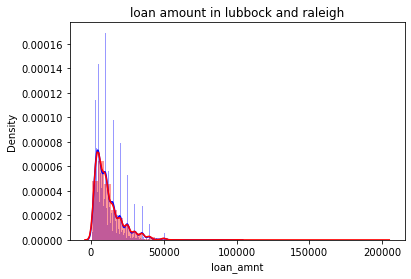

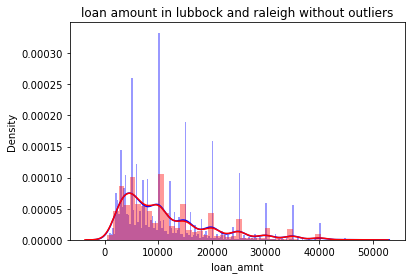

In [47]:
sns.distplot(lubbock_df.loan_amnt, color="b",bins=int(np.sqrt(tu_data.loan_amnt.nunique())));
sns.distplot(raleigh_df_merged_tu_data.loan_amnt, color="r",bins=int(np.sqrt(raleigh_df_merged_tu_data.loan_amnt.nunique()))).set_title('loan amount in lubbock and raleigh');
plt.figure()
sns.distplot(lubbock_df.query('loan_amnt <50000').loan_amnt, color="b",bins=int(np.sqrt(tu_data.loan_amnt.nunique())));
sns.distplot(raleigh_df_merged_tu_data.query('loan_amnt < 50000').loan_amnt, color="r",bins=int(np.sqrt(raleigh_df_merged_tu_data.loan_amnt.nunique()))).set_title('loan amount in lubbock and raleigh without outliers');

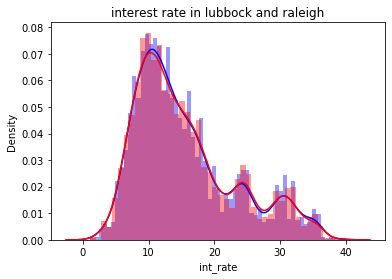

In [48]:
sns.distplot(lubbock_df.int_rate, color="b",bins=int(np.sqrt(tu_data.int_rate.nunique())));
sns.distplot(raleigh_df_merged_tu_data.int_rate, color="r",bins=int(np.sqrt(raleigh_df_merged_tu_data.int_rate.nunique()))).set_title('interest rate in lubbock and raleigh');

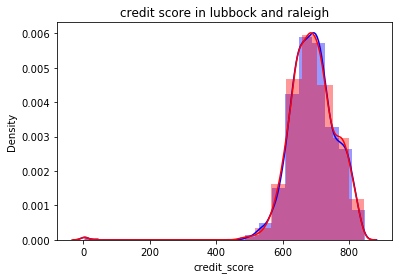

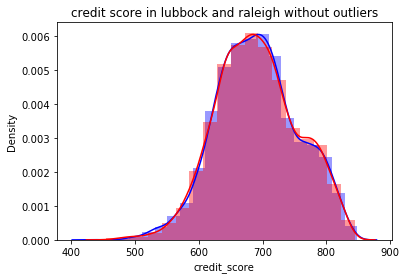

In [49]:
sns.distplot(lubbock_df.credit_score, color="b",bins=int(np.sqrt(tu_data.credit_score.nunique())));
sns.distplot(raleigh_df_merged_tu_data.credit_score, color="r",bins=int(np.sqrt(raleigh_df_merged_tu_data.credit_score.nunique()))).set_title('credit score in lubbock and raleigh');
plt.figure()
sns.distplot(lubbock_df.query('credit_score > 100').credit_score, color="b",bins=int(np.sqrt(tu_data.credit_score.nunique())));
sns.distplot(raleigh_df_merged_tu_data.query('credit_score > 100').credit_score, color="r",bins=int(np.sqrt(raleigh_df_merged_tu_data.credit_score.nunique())))\
.set_title('credit score in lubbock and raleigh without outliers');

In [50]:
raleigh_term_value_counts = raleigh_df_merged_tu_data.listing_term.value_counts()
lubbock_term_value_counts = lubbock_df.listing_term.value_counts()
print(raleigh_term_value_counts)
print("The ratio of people with term of 60 to the people with term 36 in raleigh is:", raleigh_term_value_counts.values.tolist()[1]/raleigh_term_value_counts.values.tolist()[0])
print(lubbock_term_value_counts)
print("The ratio of people with term of 60 to the people with term 36 in lubbock is:", lubbock_term_value_counts.values.tolist()[1]/lubbock_term_value_counts.values.tolist()[0])

36.0    4896
60.0    3896
Name: listing_term, dtype: int64
The ratio of people with term of 60 to the people with term 36 in raleigh is: 0.795751633986928
36.0    6266
60.0    5054
Name: listing_term, dtype: int64
The ratio of people with term of 60 to the people with term 36 in lubbock is: 0.8065751675710182


## Performing the test

Use the function you created in the file `clt.py` to plot the series of means of activation in Raleigh and Lubbock for samples of size n= 1, 10, 1000 and 1e6, and compare the means of the two histograms. To they seem to converge to the same value?

raleigh mean: 0.091 lubbock mean 0.055 n=1
raleigh mean: 0.08510000000000001 lubbock mean 0.046 n=10
raleigh mean: 0.08705299999999999 lubbock mean 0.04707900000000001 n=1000
raleigh mean: 0.086664495 lubbock mean 0.047168046000000005 n=1000000


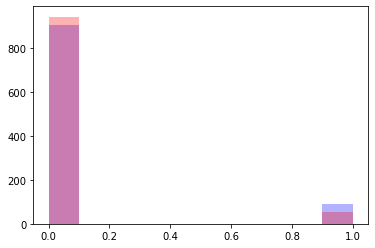

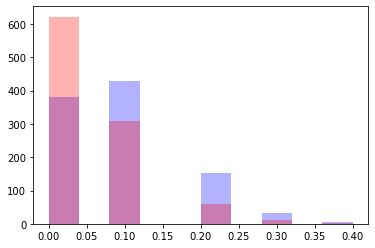

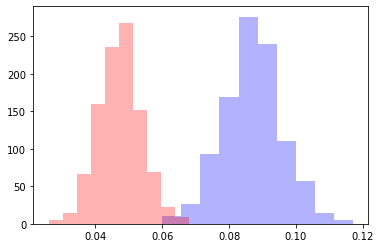

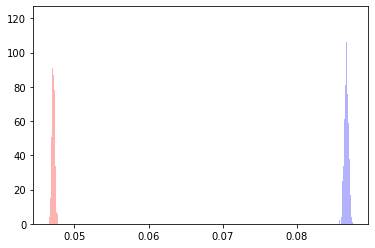

<Figure size 432x288 with 0 Axes>

In [51]:
for n in [1, 10, 1000, 1000000]:
    raleigh_mean = histogram_samples(raleigh_df_merged_tu_data.offer_accepted, n, is_alpha=0.3, plot=False, mean=True);
    lubbock_mean = histogram_samples(lubbock_df.offer_accepted, n, is_alpha=0.3, plot=True, mean=True, color_plt='red');
    print('raleigh mean:', raleigh_mean, 'lubbock mean', lubbock_mean, 'n={}'.format(n))

Apply a statistical test to see whether the activation rate in Raleigh, NC is significantly larger than Lubbock, TX. Clearly state and validate your test's assumption. 

1. What are your hypotheses?
2. Setting your confidence level at 95%, what is the probability of an error of type I in your test? What is the probability of a type II error?
3. Are the two samples significantly different? 
4. Interpret your results. Can you declare the program as successful in increasing activation? What is the probability of wrongfully declaring it successful?

1. H0 - Raleigh activation rate is not significantly larger than Lubbock
   H1 -  Raleigh activation rate is significantly larger than Lubbock
2. alpha = 0.05.
   In order to calculate beta we'll perform a ztest 

Use the `proportions_ztestz` function from `statsmodels.stats.proportion` to perform a comparison between the activation probability in Lubbock and in Raleigh. 

In [52]:

print("3.")
sample_success_raleigh = raleigh_df.offer_accepted.sum()
sample_success_lubbock = lubbock_df.offer_accepted.sum()
stat, p_value = proportions_ztest(count=[sample_success_lubbock,sample_success_raleigh], nobs=[lubbock_df.shape[0],raleigh_df.shape[0]], alternative='smaller')
print(p_value)

3.
5.475858880145861e-30


Since we get that our Pvalue is less than 5% we can decline H0 and say that Raleigh activation rate is significantly larger than Lubbock.

Interprest your results; do you observe a significant change in activation in Raleigh? What is the probability of wrongfully declaring the program successful?

As we assumed, the probabilty of wrongfully declaring the program successful is 5%.

# Testing for activation in sub-populations

Now that you applied the a/b test to the Lubbock and Raleigh datasets, it is now required that you make a similar comparison on different subsets of the data within various credit score and loan amount bins. To do so, let us first decide on how to segment our data.

You are asked to divide your data into 10 bins according to loan amount, and then divide each of those bins into 10 bins according to loan amount. The most staightforward way of doing this is by using the `pd.qcut` function; first dividing the data into 10 quantiles of credit score and then dividing each of these quantiles into 10 according to loan amount.

Divide your datasets as above and add two columns to your data which indicate the (credit_score, loan_amnt) of the bin.

In [53]:
tu_data.drop_duplicates(inplace=True)
tu_data.head()

    

,sequence_num,credit_score,listing_term,int_rate,loan_amnt,monthly_pmt,original_state
id,,,,,,,
adf5219e4cb985352184eb7fa597737e4a9777f7354f7a8a58270da147792561,d0820401b209782dae4284b3dd96b41e08c3e8566fbb33...,814,36.0,7.86,5500.0,172.0,MI
0a0f130443af4c6597bb074942970eaddeb125d398e2cca42175c56befc8a171,2f05cd66cb998e5e55f6f296344b271b2b89b996c7c037...,800,36.0,7.91,20000.0,626.0,NM
4ba9c6a38b650ee06b8b88a48621bd363cdf611e63400c6fc4bbffbd1bf20c47,20bdbfaf0006db032d8a4176add08fd4ef45abfb17c474...,653,36.0,30.51,3674.0,157.0,SD
dae3a344292e07d4b8935a453c37aef01303f21b2f37ccbd1c4408f158533acb,53084498c6bf053a4d1cf309e1b8ec234e503bb1a3dd4e...,623,60.0,23.46,14056.0,400.0,NC
8af2ae2462d012e4d85aa687a16a4f5fb64525928235da43c795f73dc0cadd04,f750c4ecac12ae1c156998ed3dff3f46d2d19f37250074...,627,60.0,25.55,8659.0,257.0,TN


In [54]:
tu_data['credit_score_bin'], bins1 = pd.qcut(tu_data['credit_score'], 10, labels=False, retbins=True)
print(bins1)
tu_data.head()

tu_data['loan_amount_bin'] = 0
bins2 = []
for i in range(10):
    tu_data.loc[tu_data['credit_score_bin'] == i,['loan_amount_bin']] , b2 = pd.qcut(tu_data.loc[tu_data['credit_score_bin'] == i, 'loan_amnt'], 10, labels=False, retbins=True)
    bins2.append(b2)
tu_data.head(20)
print(bins2)

[  1. 612. 637. 655. 672. 689. 705. 724. 750. 784. 850.]
[array([1.00000e+02, 2.50000e+03, 3.03000e+03, 3.66000e+03, 4.52500e+03,
       5.23200e+03, 6.50000e+03, 8.00000e+03, 1.00000e+04, 1.29814e+04,
       2.00200e+05]), array([4.50000e+01, 2.70000e+03, 3.46600e+03, 4.48000e+03, 5.09900e+03,
       6.52750e+03, 8.00500e+03, 1.00000e+04, 1.20000e+04, 1.60000e+04,
       1.68589e+05]), array([2.75000e+02, 3.00000e+03, 4.00000e+03, 5.00000e+03, 6.30000e+03,
       8.00000e+03, 1.00000e+04, 1.19040e+04, 1.50000e+04, 2.00000e+04,
       3.44562e+05]), array([   168. ,   3000. ,   4500. ,   5500. ,   7349.2,   9600. ,
        10000. ,  13075. ,  16040.6,  23903.6, 129306. ]), array([   275.,   3200.,   5000.,   6000.,   8000.,  10000.,  11000.,
        15000.,  18500.,  25000., 120665.]), array([1.50000e+02, 3.50000e+03, 5.00000e+03, 6.00100e+03, 8.00000e+03,
       1.00000e+04, 1.20000e+04, 1.50000e+04, 2.00000e+04, 2.50000e+04,
       1.88693e+05]), array([4.5000e+01, 3.5000e+03, 5.0000

In [55]:
raleigh_df_merged_tu_data['city'] = 'raleigh'
lubbock_df['city'] = 'lubbock'
lubbock_df = pd.merge(lubbock_df_short,tu_data, on=['id','sequence_num'])
raleigh_df = pd.merge(raleigh_df,tu_data, on=['id','sequence_num'])

Run an a/b test on each of the bins in your data and create a $10\times 10$ table containing the $p$ value of each test.

In [56]:
def calculate_pvalue(df1,df2):
    sample_success_df1 = df1.offer_accepted.sum()
    sample_success_df2 = df2.offer_accepted.sum()
    sample_size_df1 = df1.offer_accepted.count()
    sample_size_df2 = df2.offer_accepted.count()
    stat, p_value = proportions_ztest(count=[sample_success_df1,sample_success_df2], nobs=[sample_size_df1,sample_size_df2], alternative='larger')
    return p_value

In [57]:
p_value_mat = []
p_value_list = []

for i in range(10):
    for j in range(10):
        df1 = raleigh_df.query('(credit_score_bin == @i) and (loan_amount_bin == @j)')
        df2 = lubbock_df.query('(credit_score_bin == @i) and (loan_amount_bin == @j)')
        p_value_list.append(calculate_pvalue(df1,df2))
    p_value_mat.append(p_value_list)
    p_value_list = []                                       

Use the [seaborn.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function to represent your table as a heatmap. You can also use it on a suitable table of boolean values to get a more robus representation of which experiments turned out significant.

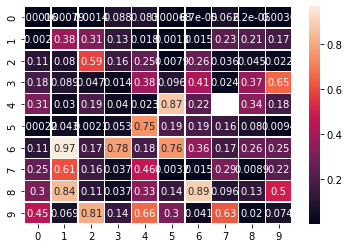

In [58]:
sns.heatmap(p_value_mat,annot=True, linewidths=.5);

What is the probability of falsely rejecting the null hypothesis in each cell? What is the probability of falsely rejecting the null hypothesis in at least one of the cells (i.e. what is the **family wise error rate**)?

In other words, given that we made $m$ experiments, with confidence level $\alpha$, what is the probabilty $\mathbb{P}\left(\bigcup_i X_i \le q_{\alpha}\right)$? 

_Note_: you may assume that sampling from different bins are independent.

The probability of falsely rejecting the null hypothesis in each cell is 0.05 by the assumption.

In [59]:
p_all_is_right = 0.95 **(100) 
p_at_least_1_mistake = 1 - p_all_is_right
print("the probability of falsely rejecting the null hypothesis in at least one of the cell is:", p_at_least_1_mistake)

the probability of falsely rejecting the null hypothesis in at least one of the cell is: 0.994079470779666


## Bonferroni correction 

One way of assuring that your FWER remains below $\alpha=0.05$ is to apply a <a href="https://en.wikipedia.org/wiki/Bonferroni_correction">**Bonferroni correction**</a>. This means that we set the signficance level of each individual test to $\alpha/m$, where $m=100$ is the number of tests (see, e.g., Wikipedia for an explanation). 

Use a Bonferroni correction on your segmented a/b test and output a $10\times10$ table of boolean values, indicating which test gave a significant result under this correction.

In [60]:
np.array(p_value_mat) < 0

array([[False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False]])

How many of your tests came out significant under this correction?

non of them

Visualize your result using the [seaborn.heatmap]() function and compare to the previous heatmap.

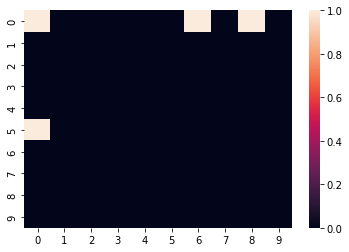

In [61]:
sns.heatmap(np.array(p_value_mat) < 0.0005)

## BH correction 

The Bonferroni correction is often criticized for being too restrictive, as you probably noticed in the last subsection. A more commonly used method for correcting $\alpha$ values is the Benjamini-Hochberg method. You can <a href="https://www.youtube.com/watch?v=K8LQSvtjcEo">check out the quest</a> for a nice explanation about it.

Start by arranging the $p$-values of your original test as a series and listing them in ascending order. You can use the `pd.DataFrame.stack` and `pd.Series.sort_values` methods.

In [62]:
p_values = pd.DataFrame(np.array(p_value_mat).flatten(), index=np.arange(100), columns=['p_values']).sort_values('p_values').reset_index()
p_values_sorted = pd.Series(np.array(p_value_mat).reshape(100,)).sort_values().values
p_values_sorted 
p_values['index']

0      8
1      6
2      0
3     50
4      5
      ..
95    81
96    45
97    86
98    61
99    47
Name: index, Length: 100, dtype: int64

Plot your sorted $p$-values

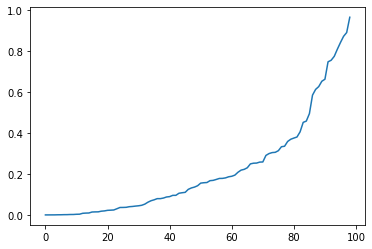

In [63]:
plt.plot(p_values_sorted)
plt.show()

For each entry of the new series, compute the value compute the value $\frac{i}{m}\cdot\alpha$, where $i$ is the ordinal place of the entry (i.e. 1,2,...len(series)), $m=100$ and $\alpha=0.05$ as above. Add a plot of these values to your $p$-values plot.

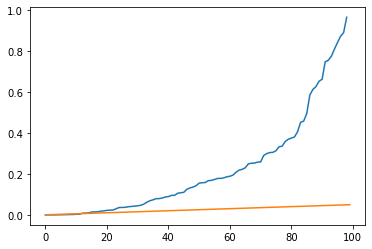

In [64]:
s = np.array([0.05*i/100 for i in range(1, 101)])
plt.plot(p_values_sorted)
plt.plot(s)
plt.show()

Find the largest index $i$ for which the $p$-value in the $i$-th place in the series is smaller than $\frac{i}{m}\cdot\alpha$. That is- the last index in the plot you just created where the $p$-values line lies below the _adjusted_-$\alpha$ line.

In [65]:
p_values['alpha'] = s
p_values['reject_H0_hypothesis'] = (p_values_sorted < s)
p_values[p_values.reject_H0_hypothesis].tail(1)

,index,p_values,alpha,reject_H0_hypothesis
11,9,0.003552,0.006,True


Reject the null hypothesis for all test before and including this index, and accept it for all others. Reformat your table into a $10\times 10$ dataframe; for which bins did we get a significant result in the corrected test?

In [66]:
p_values['credit_score_bin'] = p_values['index']//10
p_values['loan_amount_bin'] = p_values['index']%10
pd.pivot_table(p_values[['reject_H0_hypothesis', 'credit_score_bin', 'loan_amount_bin']],
               values='reject_H0_hypothesis', index=['credit_score_bin'],
                    columns=['loan_amount_bin'])

loan_amount_bin,0,1,2,3,4,5,6,7,8,9
credit_score_bin,,,,,,,,,,
0,True,True,True,False,False,True,True,False,True,True
1,True,False,False,False,False,True,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
5,True,False,True,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,True,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False


Visualize your result using the [seaborn.heatmap]() function and compare to the previous heatmap.

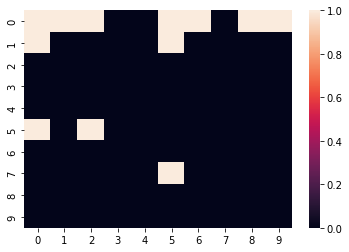

In [67]:
sns.heatmap((p_values.set_index('index').sort_index()).reject_H0_hypothesis.values.reshape(10,10))

### Validating your results

You can validate your results (for both corrections) using the <a href= "https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html">`statsmodels.stats.multitest.multipletests`</a> package.

is my results equivalent to "multipletests"s? True


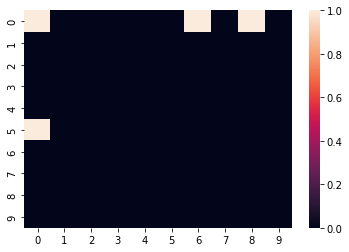

In [68]:

to_rject, _, _, _ = multipletests(np.array(p_value_mat).flatten(), 0.05, 'bonferroni')
sns.heatmap(to_rject.reshape(10,10))
print('is my results equivalent to "multipletests"s?', np.all((np.array(p_value_mat) < 0.0005) == to_rject.reshape(10,10)))

is my results equivalent to "multipletests"s? True


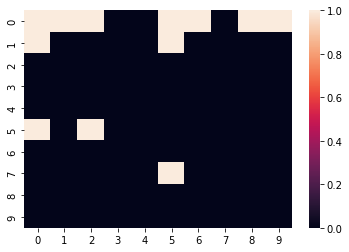

In [69]:
to_rject, _, _, _ = multipletests(np.array(p_value_mat).flatten(), 0.05, 'fdr_bh')
sns.heatmap(to_rject.reshape(10,10))
print('is my results equivalent to "multipletests"s?', np.all((p_values.set_index('index').sort_index()).reject_H0_hypothesis.values == to_rject))